In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import itertools as it
from tqdm.notebook import tqdm

In [2]:
import seaborn as sns
%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numba

In [4]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    
    else:
        return(np.exp(np.log(lmbda*y + 1) / lmbda))

In [5]:
# pd.read_excel?

In [6]:
crime = pd.read_excel('crime.xlsx', sheet_name='pandas')
crime.set_index(pd.to_datetime(crime.month), inplace=True)
crime.drop(['month'], axis=1, inplace=True)
crime

,Total_crimes,Serious_and_especially_serious,Causing_huge_damage,Ecological,Terrorism,Extremism,Murder,Serious_harm_to_health,Rape_assault,Razboy,Grabezh,Theft,Vehicle_theft,Fraud_scam,Hooligan,Drugs,Weapons
month,,,,,,,,,,,,,,,,,
2003-01-01,214587,88203,20162,1216,630,13,2749,5559,574,3698,16455,81014,3549,7731,10560,16006,4661
2003-02-01,221928,88863,20889,1701,678,5,2444,4732,515,3678,15724,95970,3697,7607,10816,16839,5364
2003-03-01,248452,101349,24053,1817,809,10,2864,4851,560,4406,15674,79420,4327,9437,11813,20176,5938
2003-04-01,236299,91625,19754,2449,892,10,2919,4722,668,4322,14440,95215,5345,7824,12636,16614,5230
2003-05-01,230931,89615,17519,3530,796,20,2713,4895,688,3781,14209,94505,6374,7122,12234,14413,5112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,166208,38967,64283,1858,122,48,555,1570,306,537,3612,67006,1903,21557,155,15100,1945
2019-10-01,199038,53319,81775,2322,111,52,668,1846,223,652,3984,81053,2197,27980,180,20510,1744
2019-11-01,148104,31652,49623,1581,149,27,622,1467,246,507,3403,57434,1344,19794,132,11067,1742


## Будем рассматривать данные по преступлениям, связанными с кражей

In [7]:
CATEGORY = 'Theft'

In [8]:
data = crime[[CATEGORY]]
data.columns = ['amount']
data['amount'] = data.amount.astype(float)
data

,amount
month,
2003-01-01,81014.0
2003-02-01,95970.0
2003-03-01,79420.0
2003-04-01,95215.0
2003-05-01,94505.0
...,...
2019-09-01,67006.0
2019-10-01,81053.0
2019-11-01,57434.0


### Строим график

Text(0, 0.5, 'Theft amount')

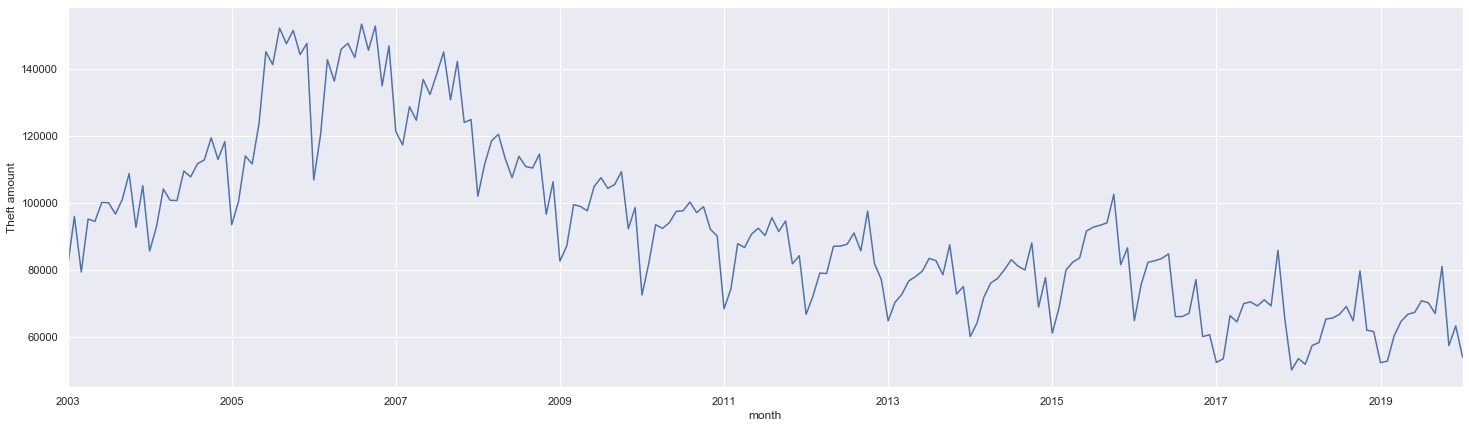

In [9]:
plt.figure(figsize(25, 7))
data.amount.plot()
plt.ylabel('%s amount' % CATEGORY)

### Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p = 0.629333


<Figure size 1080x720 with 0 Axes>

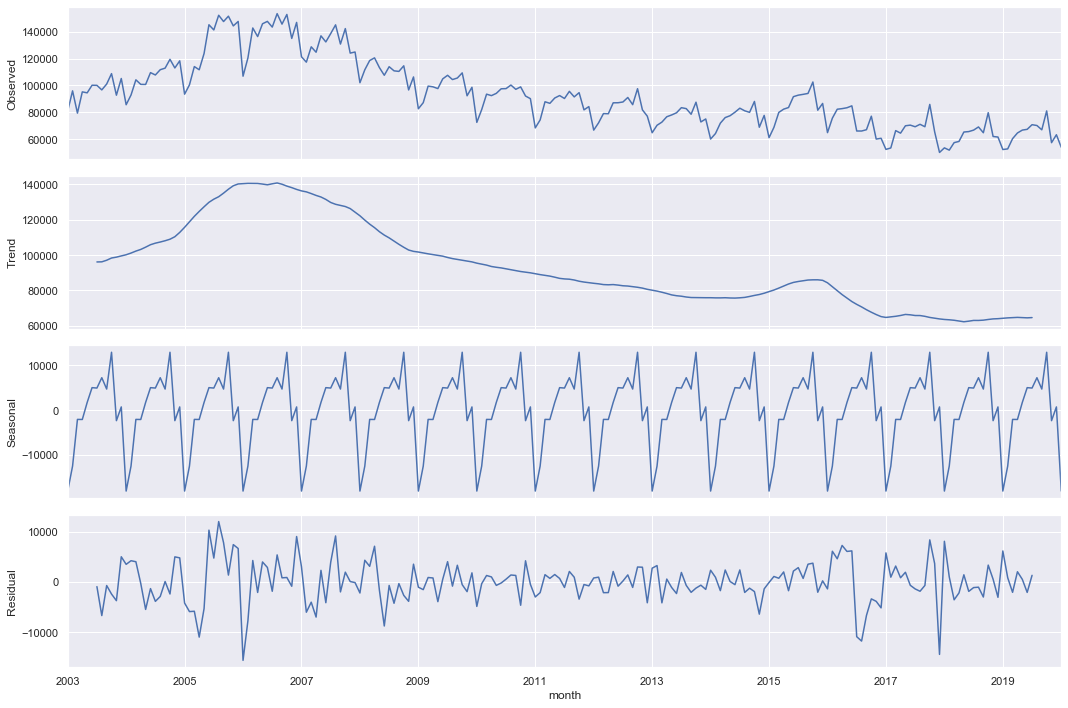

In [10]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount).plot()

print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount)[1])

Смотрим на значение $p_{value}$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

Сразу видны следующие особенности данных:
* убывающий тренд
* Падающая со временем дисперсия (*т.е она нестабильная*)
* периодичность (период = 12 месяцев)
* Остатки вроде бы не имеют структуры

In [11]:
season = 12

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [12]:
NEED = True

In [13]:
if NEED:
    data['amount_boxcox'], lmbda = stats.boxcox(data.amount)
else:
    data['amount_boxcox'], lmbda = data.amount, 1

Оптимальный параметр преобразования Бокса-Кокса: -0.173733
Критерий Дики-Фуллера: p = 0.616248


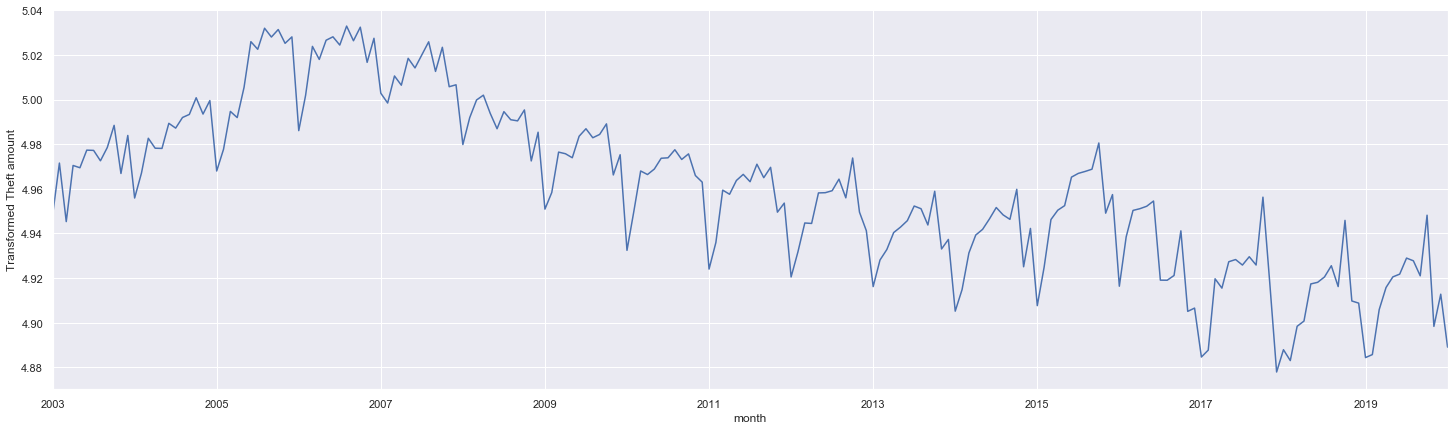

In [14]:
plt.figure(figsize(25, 7))
data.amount_boxcox.plot()
plt.ylabel('Transformed %s amount' % CATEGORY)

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox)[1])

In [16]:
data.amount_boxcox

month
2003-01-01    4.948095
2003-02-01    4.971527
2003-03-01    4.945301
2003-04-01    4.970449
2003-05-01    4.969427
                ...   
2019-09-01    4.921007
2019-10-01    4.948163
2019-11-01    4.898344
2019-12-01    4.912775
2020-01-01    4.889045
Name: amount_boxcox, Length: 205, dtype: float64

Размах дисперсии ощутимо уменьшился.

Смотрим на значение $p_{value}$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

Если остатки не имеют структуры, то все хорошо. Если не удалось избавиться от тренда, то пробуем применить ***сезонное дифференцирование***

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и визуально в данных виден тренд. Попробуем сначала ***сезонное дифференцирование*** и позже сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p = 0.264439


<Figure size 1080x720 with 0 Axes>

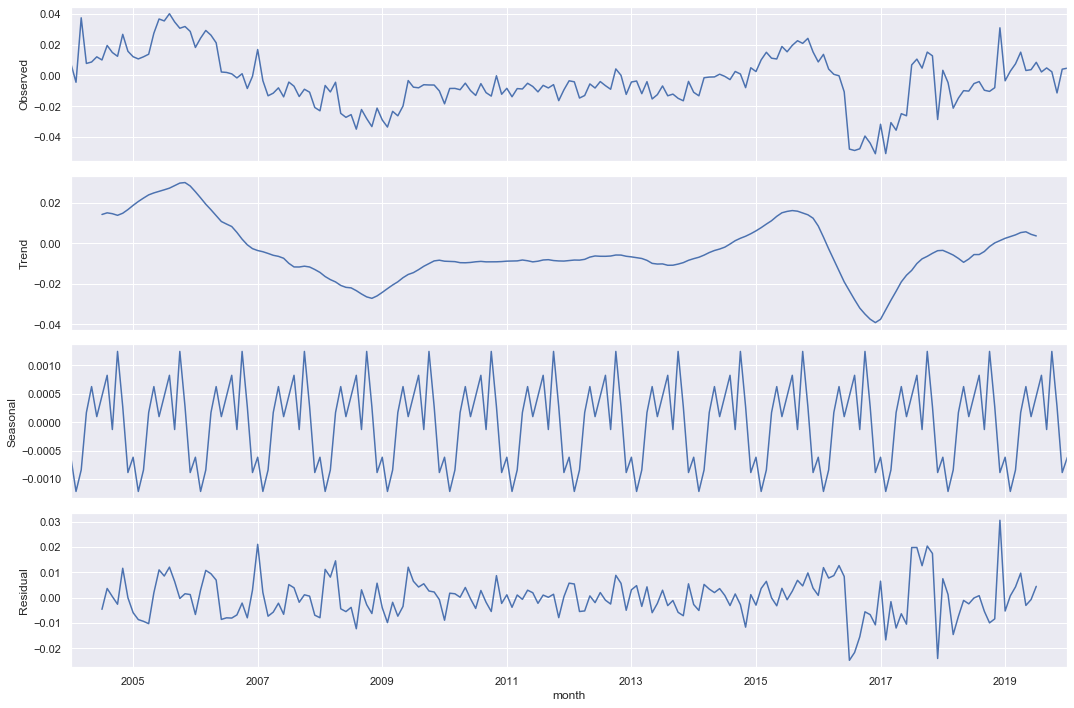

In [17]:
data['amount_boxcox_diff'] = data.amount_boxcox - data.amount_boxcox.shift(season)

plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount_boxcox_diff[season:]).plot()

print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox_diff[season:])[1])

Смотрим на значение $p_{value}$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности

Если остатки не имеют структуры, то все хорошо. Если не удалось избавиться от тренда, то пробуем применить ***обычное дифференцирование***

Критерий Дики-Фуллера: p = 0.000000


<Figure size 1080x720 with 0 Axes>

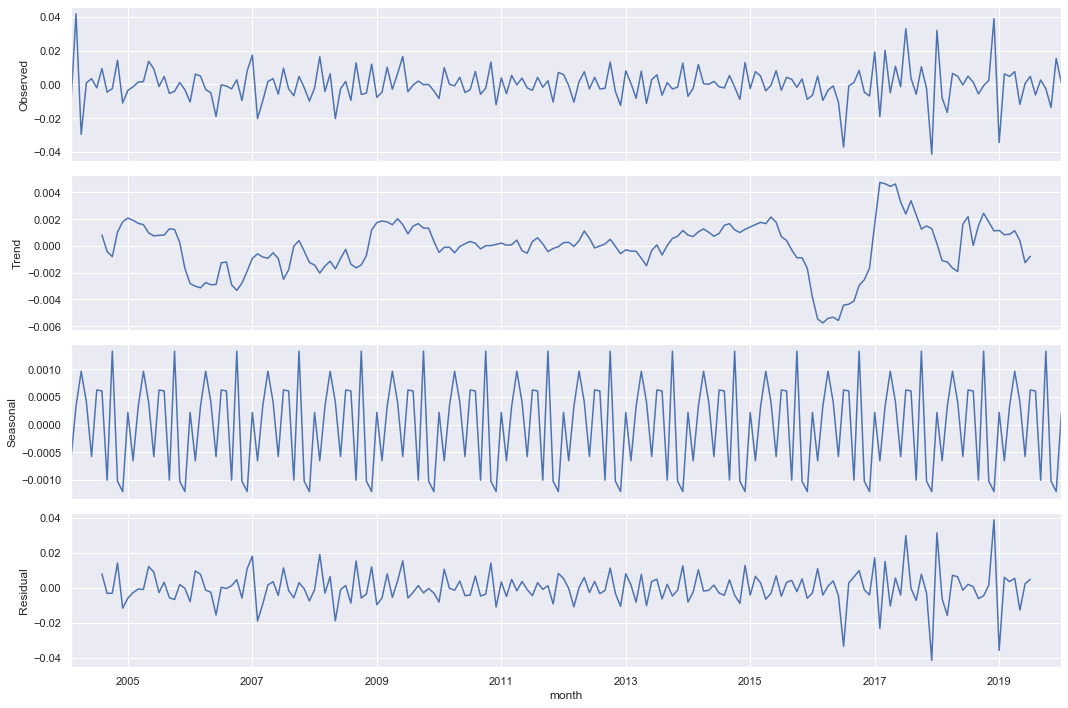

In [18]:
data['amount_boxcox_diff2'] = data.amount_boxcox_diff - data.amount_boxcox_diff.shift(1)

plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.amount_boxcox_diff2[season + 1:]).plot()   

print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.amount_boxcox_diff2[season + 1:])[1])

Смотрим на значение $p_{value}$ критерия Дики-Фуллера:
* $p_{value} \ll 0.05$ => гипотеза нестационарности ряда отвергается
* $p_{value} \gg 0.05$ => есть основания не отвергать гипотезу нестационарности ряда

Если остатки не имеют структуры, то все хорошо.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

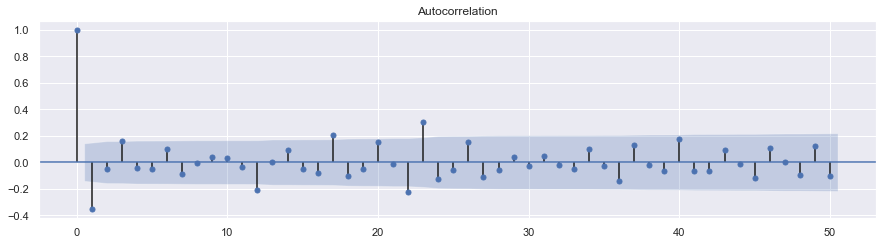

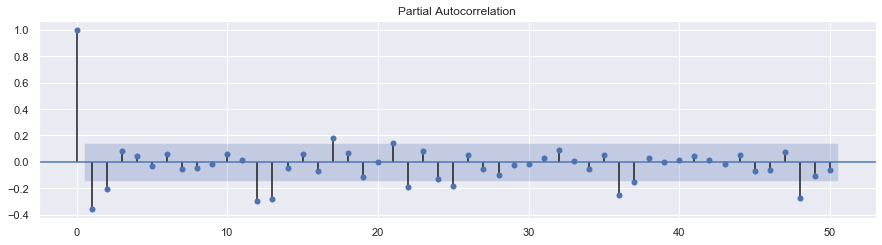

In [19]:
plt.figure(figsize(15, 8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(
    data.amount_boxcox_diff2[season + 1:].values.squeeze(), # внимательнее amount_boxcox_diff[season:]
    lags=50,
    ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data.amount_boxcox_diff2[season + 1:].values.squeeze(), # внимательнее amount_boxcox_diff[season:]
    lags=50,
    ax=ax)
pylab.show()

$Q = 1$ - последний значимый лаг, кратный сезонности<br>
$q = 3$ - последний значимый лаг на ACF, меньший чем значение сезонности<br>
$P = 4$ - последний значимый лаг, кратный сезонности<br>
$p = 2$ - последний значимый лаг на PACF, меньший чем значение сезонности<br>

In [20]:
Qs = range(0, 2)
qs = range(0, 4)

Ps = range(0, 5)
ps = range(0, 3)

D = 1
d = 1

In [21]:
parameters = it.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

120

#### Запускаем в работу нашу модель

Возможны какие-то ошибки, решаем их таким образом:
* либо добавляем их в исключения


* либо добавляем параметры в `SARIMAX` модель (от этого может стать хуже модель)
    * можно попробовать `enforce_stationarity=False`
    * можно еще `initialization='approximate_diffuse'`

In [22]:
def optimizeSARIMA(parameters_list, d, D, season):
    '''
    Returns a dataframe with parameters for SARIMA model and corresponding by AIC
    
    parameters_list - list with (p, q, P, Q) tuples
    d - diff order in ARIMA model
    D - seasonal diff order
    season - length of season
    '''
    results = []
    best_aic = float('inf')
    
    warnings.filterwarnings('ignore')
    
    for param in tqdm(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        # или просто кидает ошибку типа LinAlgError или ValueError
        try:
            model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                              order=(param[0], d, param[1]), 
                                              seasonal_order=(param[2], D, param[3], season)).fit(disp=-1)
            
        # выводим параметры, на которых модель не обучается и переходим к следующему набору
        except:
            model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                              order=(param[0], d, param[1]), 
                                              seasonal_order=(param[2], D, param[3], season), 
                                              initialization='approximate_diffuse').fit(disp=-1)
            
        aic = model.aic        
        results.append([param, aic])
    
    warnings.filterwarnings('default')
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем в возрастающем порядке, чем меньше AIC, тем лучше
    result_table = result_table.sort_values(by = 'aic', ascending=True).reset_index(drop=True)
    
    return result_table
    

In [23]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, season)


Wall time: 20min 20s


Выводим удачные модели:

In [24]:
result_table.head()

,parameters,aic
0,"(0, 1, 4, 0)",-1299.269880
1,"(2, 0, 4, 0)",-1298.408698
2,"(1, 1, 4, 0)",-1297.212666
3,"(1, 0, 4, 0)",-1297.040460
4,"(0, 1, 4, 1)",-1296.647377


#### Лучшая модель:

In [ ]:
# если не обучал модель, то используй готовые параметры
best_param = (0, 1, 4, 0)
D = 1
d = 1

In [25]:
# если обучал модель
best_param = result_table.parameters[0]
best_param

(0, 1, 4, 0)

In [26]:
best_model = sm.tsa.statespace.SARIMAX(data.amount_boxcox, 
                                              order=(best_param[0], d, best_param[1]), 
                                              seasonal_order=(best_param[2], D, best_param[3], season)).fit(disp=-1)

print(best_model.summary())

C:\Users\tsark\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                      amount_boxcox   No. Observations:                  205
Model:             SARIMAX(0, 1, 1)x(4, 1, 0, 12)   Log Likelihood                 655.635
Date:                            Wed, 01 Apr 2020   AIC                          -1299.270
Time:                                    20:37:37   BIC                          -1279.725
Sample:                                01-01-2003   HQIC                         -1291.354
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3984      0.045     -8.896      0.000      -0.486      -0.311
ar.S.L12      -0.6401      0.064   

Рассмотрим остатки модели:

Критерий Стьюдента: p = 0.526997
Критерий Дики-Фуллера: p = 0.000000


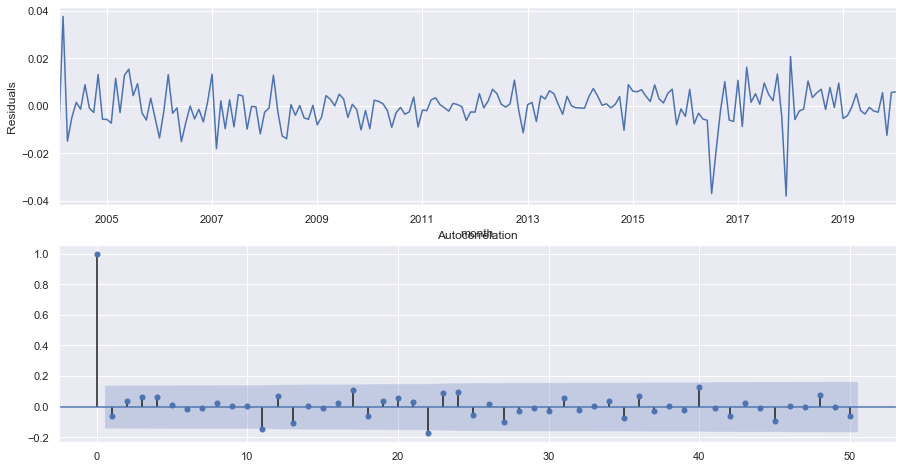

In [27]:
plt.figure(figsize(15, 8))
plt.subplot(211)
best_model.resid[season + 1:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[season + 1:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p = %f" % stats.ttest_1samp(best_model.resid[season + 1:], 0)[1])
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(best_model.resid[season + 1:])[1])

* Критерий Стьюдента: $p_{value} = 0.94 >> 0.05$ - **остатки несмещены**
* Критерий Дики-Фуллера: $p_{value} = 0.00 < 0.05$ - **остатки стационарны**
* Критерий Льюнга-Бокса: $p_{value} = 0.08 > 0.05$  - **остатки неавтокоррелированы** (но неуверен)

Продемонстрируем как работает наша модель

In [28]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)


C:\Users\tsark\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tsark\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


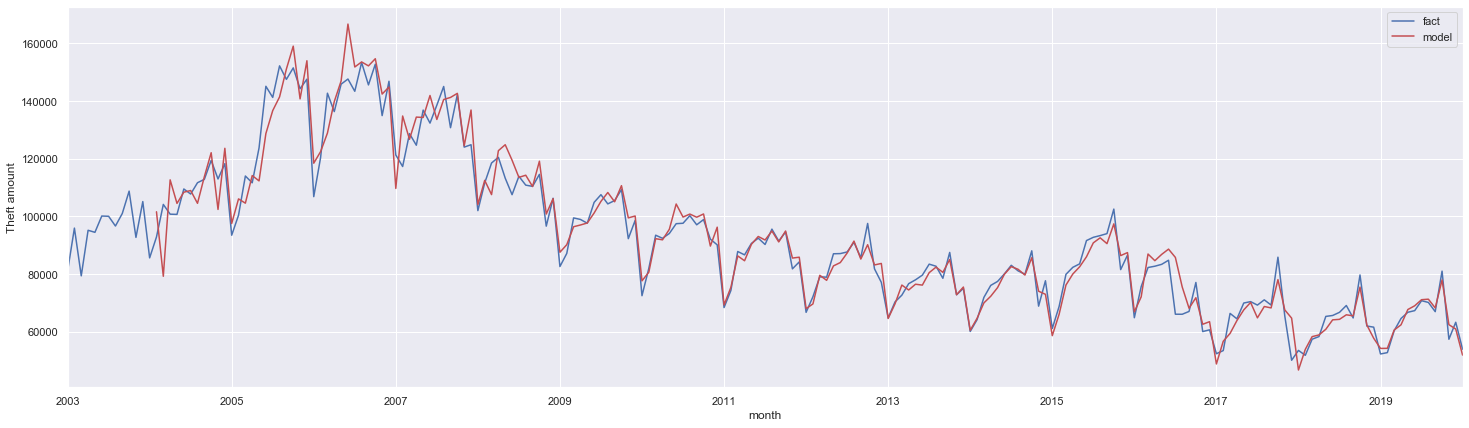

In [29]:
plt.figure(figsize(25, 7))
data.amount.plot(color='b', label='fact')
data.model[season + 1:].plot(color='r', label='model')
plt.ylabel('%s amount' % CATEGORY)
plt.legend()
pylab.show()

### Прогноз

Перед тем как прогнозировать, узнай количество записей в `data` и также последнюю дату, от неё и прогнозируем

In [30]:
data2 = data[['amount']]
count = data2.shape[0] - 1
how_much = 12

In [31]:
date_list = [datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(how_much)]
future = pd.DataFrame(index=date_list, columns= data2.columns)

In [32]:
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=count, end=count+how_much), lmbda)

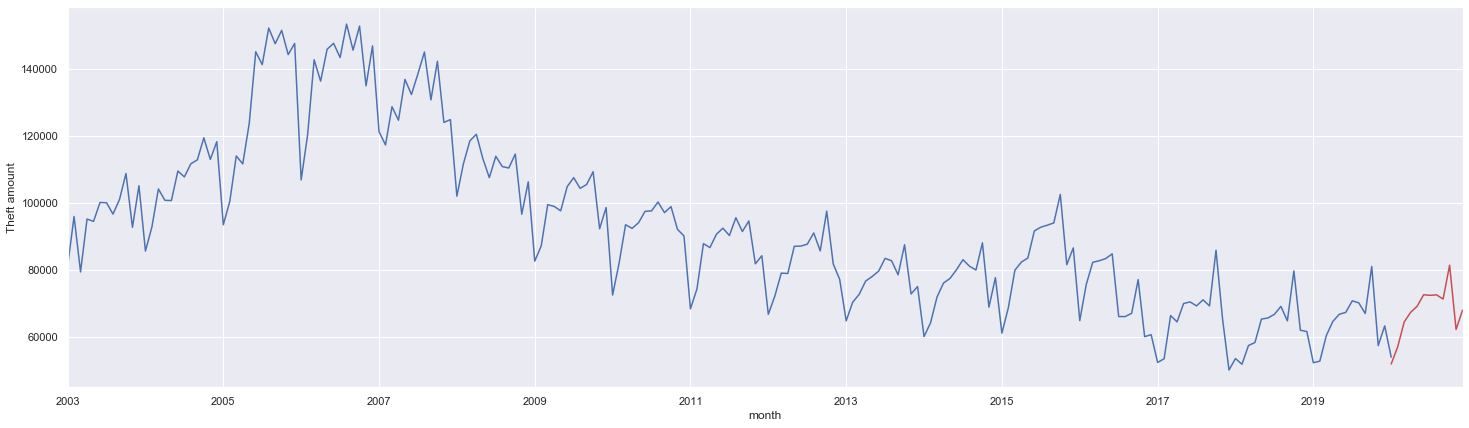

In [33]:
plt.figure(figsize(25, 7))
data.amount.plot(color='b')
data2.forecast.plot(color='r')
plt.ylabel('%s amount' % CATEGORY)
pylab.show()

In [34]:
data2[['forecast']].tail(how_much)

,forecast
2020-01-01,51951.038489
2020-02-01,57059.195839
2020-03-01,64489.488857
2020-04-01,67376.046470
2020-05-01,69186.376266
2020-06-01,72610.977924
2020-07-01,72442.839825
2020-08-01,72580.626313
2020-09-01,71321.559518
2020-10-01,81441.085615
